In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.fft import fft,fftfreq
from scipy import signal
from sklearn.preprocessing import normalize
import librosa
import soundfile as sf
from matplotlib import cm # for a scatter plot
from mpl_toolkits.mplot3d import Axes3D

In [37]:
def plot_fft(y,fs):
    N=len(y)
    T = 1/fs
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]
    plt.figure(figsize=(14,4))
    plt.scatter(xf, 2.0/N * np.abs(yf[0:N//2]))
    return

def minmax_normalize(data_set):
    data_normalized = (data_set-np.min(data_set))/(np.max(data_set)-np.min(data_set))
    return data_normalized

def standardize(data_set):
    data_normalize = (data_set-np.mean(data_set))/np.std(data_set)
    return data_normalize

def butter_bandpass(lowcut, highcut, fs, order=9):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=9):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def analyze(str_filename,Clean_space):


    df_0 = pd.read_csv(Clean_space)
    df = pd.read_csv(str_filename)
    fs = 62500.0
    T = 1/fs
    N= df.shape[0]
    y = np.array(df.Audio) - np.array(df_0.Audio)
    t = np.arange(0,N)*T


    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]

    #Band Pass filtering
    
    lowcut = 15000.0
    highcut = 19000.0

    b, a = butter_bandpass(lowcut, highcut, fs, order=12)
    w, h = signal.freqz(b, a, worN=30000)

    y_filtered_sound = butter_bandpass_filter(y, lowcut, highcut, fs, order=12)

    yf_filtered = fft(y_filtered_sound)
    xf_filtered = fftfreq(N, T)[:N//2]

    # Plot the frequency response and waveforms
    fig,ax = plt.subplots(4,1, figsize=(16,16))
    ax[0].plot(t, y)
    ax[0].title.set_text('Recieved Echo')

    ax[1].plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    ax[1].title.set_text('FFT of the Recieved Echo')

    ax[2].plot(t, y_filtered_sound)
    ax[2].title.set_text('BandPass filtered Recieved Echo')

    ax[3].plot(xf_filtered, 2.0/N * np.abs(yf_filtered[0:N//2]))
    ax[3].set_xlim((10000,22000))
    ax[3].title.set_text('FFT of BP-Recieved Echo')

    plt.show()

def butter_lowpass(cutoff, fs , order=4):
    nyq_freq = fs/2
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y  

def extract_peak_frequency(data, sampling_rate):
    fft_data = np.fft.fft(data)
    freqs = np.fft.fftfreq(len(data))
    
    peak_coefficient = np.argmax(np.abs(fft_data))
    peak_freq = freqs[peak_coefficient]
    
    return abs(peak_freq * sampling_rate)

def Phase_lag_Hilbert(x1,x2,sampling_rate):
    
    x1h = signal.hilbert(x1)
    x2h = signal.hilbert(x2)
    omega = (extract_peak_frequency(x1,sampling_rate) + extract_peak_frequency(x2,sampling_rate))/2
             
    c = np.inner( x1h, np.conj(x2h) ) / np.sqrt( np.inner(x1h,np.conj(x1h)) * np.inner(x2h,np.conj(x2h)) )
    phase_diff = np.angle(c)/(np.pi*2*omega)
    return(-phase_diff * sampling_rate) # return the delayed number of sample points


def Phase_lag_xcc(A,B,sampling_rate):
    
    # Find cross-correlation
    xcorr = signal.correlate(A, B)
    lags = signal.correlation_lags(len(A), len(B))
    # delta time array to match xcorr
    omega = (extract_peak_frequency(A,sampling_rate) + extract_peak_frequency(B,sampling_rate))/2

    recovered_time_shift = lags[np.argmax(xcorr)]

    return(recovered_time_shift*(1/1000)*(np.pi*2*omega))

In [38]:
F_min = 18000 # 16KHz
F_max = 24000 # 20KHz
sampling_rate = 192000 # 384KHz

FMCW_duration = 0.08
silent_duration = 0.02

In [44]:
chirp_signal = librosa.chirp(fmin=F_min,fmax=F_max,sr=sampling_rate,duration=FMCW_duration,linear=False)


tone = librosa.tone(0, sr=sampling_rate, length=int(silent_duration*sampling_rate))
silent = np.zeros(int(silent_duration*sampling_rate))

transmition_signal = np.array([])

for i in range(3):
    transmition_signal = np.concatenate((transmition_signal ,tone,chirp_signal ,tone))
transmition_signal = np.concatenate((transmition_signal ,tone,tone,tone,tone,tone))

filtered_transmition_signal = butter_bandpass_filter(transmition_signal,F_min,F_max,fs=sampling_rate,order=9)

final = np.array([])
for j in range(50):
    final = np.concatenate((final,filtered_transmition_signal))

sf.write("TR 18-24_filtered.wav",final,sampling_rate)

(0.0, 40000.0)

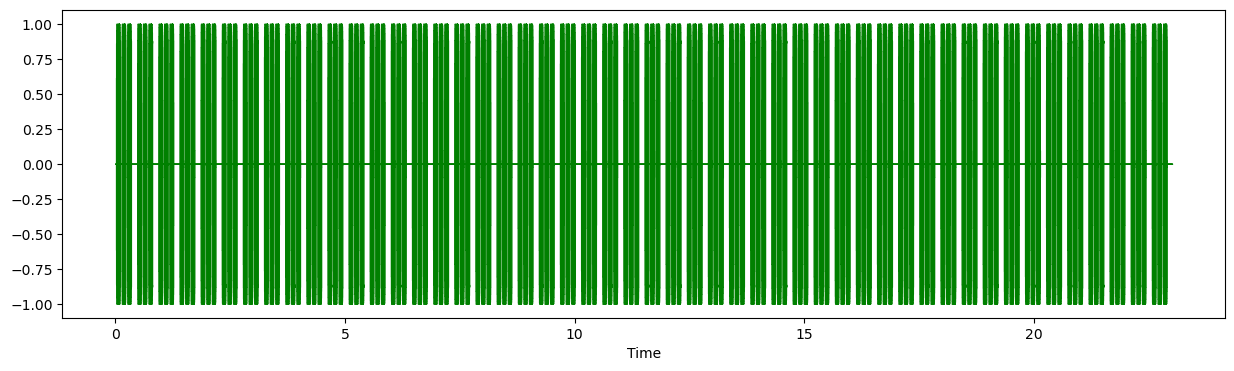

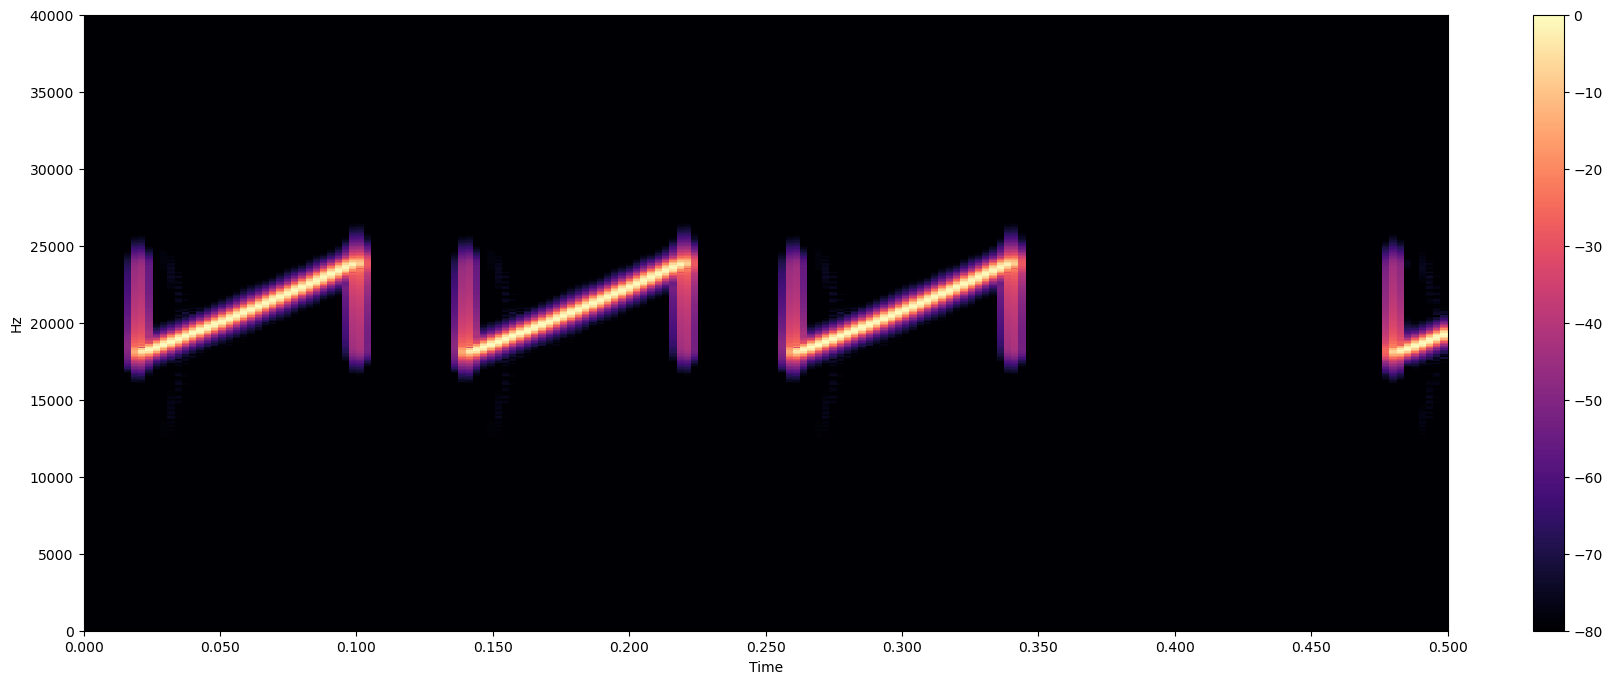

In [45]:
sound,sr = librosa.load("TR 18-24_filtered.wav",sr=sampling_rate)
plt.figure(figsize=(15,4))
#plt.plot(time,soundl)
librosa.display.waveshow(sound,sr=sampling_rate,color="green")
#plt.xlim((0,1))

D = librosa.amplitude_to_db(np.abs(librosa.stft(sound)), ref=np.max)
plt.figure(figsize=(22,8))
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',sr=sampling_rate)                         
plt.colorbar()
plt.xlim((0,0.5))
plt.ylim((0000,40000))

In [41]:
def chirp_confirm(s,fs,bias):
    key = np.where(s>0.0015)[0][0]
    curr = key + int(0.12*fs)
    if (s[curr]>0.02):
        curr = curr+int(0.12*fs)
        if (s[curr]>0.02):
            curr = curr+int(0.22*fs)
            if (s[curr]>0.02):
                return(key-int(0.02*fs))
    chirp_confirm(s[curr:],fs,bias+key)

def segment_chirp(recieved_wave,fs):
    s = recieved_wave[int(0.1*fs):int(2*fs)]
    key = chirp_confirm(s,fs)
    return(recieved_wave[key: key+int(0.4*fs)])

In [42]:
def segment_chirp(recieved_wave,fs):
    s = recieved_wave[int(0.3*fs):int(2*fs)]
    chirp_confirm=False
    
    while(chirp_confirm==False):
        key = np.where(s>0.0015)[0][0]
        curr = key + int(0.12*fs)
        if (s[curr]>0.02):
            curr = curr+int(0.12*fs)
            if (s[curr]>0.02):
                curr = curr+int(0.22*fs)
                if (s[curr]>0.02):
                    P = key + int(0.3*fs)
                    break
        key=curr

    return(recieved_wave[P: P+int(0.4*fs)])



In [43]:
def chirp_confirm(s,fs,bias):
    key = np.where(s>0.0015)[0][0]
    curr = key + int(0.12*fs)
    #print(curr)
    if (s[curr]>0.0015):
        curr = curr+int(0.12*fs)
        if (s[curr]>0.0015):
            curr = curr+int(0.22*fs)
            if (s[curr]>0.0015):
                return(key-int(0.02*fs)+bias)
    #print(curr)
    new = curr-int(0.08*fs)
    chirp_confirm(s[new:],fs,bias+new)

def segment_chirp(recieved_wave,fs):
    s = recieved_wave[int(0.4*fs):int(2*fs)]
    key = chirp_confirm(s,fs,int(0.4*fs))
    return(recieved_wave[key: key+int(0.4*fs)])